In [1]:
import numpy as np
import pymc3 as pm
from pymc3.math import switch
from scipy import optimize
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

/home/calsaverini/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Simple Model (no parameters)

Suponha o seguinte modelo:

| R    |  P(R)|
|------|------|
| 0    | 0.95 |
| 1    | 0.05 |

| R   | S  |  P(S / R)|
|-----|----|----------|
| 0   | 0  | 0.8      |
| 0   | 1  | 0.2      |
| 1   | 0  | 0.99     |
| 1   | 1  | 0.01     |

| R   | S  |  P(G=1 / R, S)|
|-----|----|----------|
| 0   | 0  | 0.01     |
| 0   | 1  | 0.9      |
| 1   | 0  | 0.95     |
| 1   | 1  | 0.99     |

In [2]:
p_rain = np.array([0.95, 0.05])
p_sprinkler = np.array([[0.8, 0.2], [0.99, 0.01]])
p_grass_wet = np.array([[0.01, 0.9], [0.95, 0.99]])

Observamos a grama molhada. Choveu ou não?

Pelo teorema de Bayes:
$$
    P(R = 1 | G = 1) = \frac{P(G = 1 | R = 1) p(R = 1)}{P(G = 1)}
$$

In [3]:
p_grass_given_rain = p_grass_wet[1, 0] * p_sprinkler[1, 0] + p_grass_wet[1, 1] * p_sprinkler[1, 1]
p_grass_given_whatever = (p_grass_wet[1, 0] * p_sprinkler[1, 0] + p_grass_wet[1, 1] * p_sprinkler[1, 1]) * p_rain[1] + (p_grass_wet[0, 0] * p_sprinkler[0, 0] + p_grass_wet[0, 1] * p_sprinkler[0, 1]) * p_rain[0]
p_grass_given_rain * p_rain[1] / p_grass_given_whatever

0.21015390058376085

# MCMC

In [17]:
with pm.Model() as model:
    p_rain = pm.Beta('p_rain', alpha=1, beta=1, shape=2)
    p_sprinkler_given_rain = pm.Beta('p_sprinkler_given_rain', alpha=1, beta=1, shape=2)
    p_sprinkler_given_no_rain = pm.Beta('p_sprinkler_given_no_rain', alpha=1, beta=1, shape=2)
    
    p_grass_given_sprinkler_and_rain = pm.Beta('p_grass_given_sprinkler_and_rain', alpha=1, beta=1, shape=2)
    p_grass_given_no_sprinkler_and_rain = pm.Beta('p_grass_given_no_sprinkler_and_rain', alpha=1, beta=1, shape=2)
    p_grass_given_sprinkler_and_no_rain = pm.Beta('p_grass_given_sprinkler_and_no_rain', alpha=1, beta=1, shape=2)
    p_grass_given_no_sprinkler_and_no_rain = pm.Beta('p_grass_given_no_sprinkler_and_no_rain', alpha=1, beta=1, shape=2)
    
    historical_rain = pm.Categorical("historical_rain", p=p_rain, shape=3, observed = np.array([1, 0, 0]))
    historical_p_sprinkler = switch(historical_rain, p_sprinkler_given_no_rain, p_sprinkler_given_rain)
    historical_sprinkler = pm.Categorical("historical_sprinkler", p=historical_p_sprinkler, shape=3, observed = np.array([0, 1, 0]))

#     historical_p_grass_no_rain = switch(historical_sprinkler, p_grass_given_no_sprinkler_and_no_rain, p_grass_given_sprinkler_and_no_rain)
#     historical_p_grass_rain = switch(historical_sprinkler, p_grass_given_no_sprinkler_and_rain, p_grass_given_sprinkler_and_rain)
#     historical_p_grass = p=switch(historical_rain, historical_p_grass_no_rain, historical_p_grass_rain)
#     historical_grass = pm.Categorical("historical_grass", p=historical_p_grass, shape=20, observed = np.array([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1]))
    
#     today_rain = pm.Categorical("rain", p=p_rain)
    
#     p_sprinkler = switch(today_rain, p_sprinkler_given_no_rain, p_sprinkler_given_rain)
#     today_sprinkler = pm.Categorical("sprinkler", p=p_sprinkler)
    
#     p_grass_no_rain = switch(today_sprinkler, p_grass_given_no_sprinkler_and_no_rain, p_grass_given_sprinkler_and_no_rain)
#     p_grass_rain = switch(today_sprinkler, p_grass_given_no_sprinkler_and_rain, p_grass_given_sprinkler_and_rain)
#     p_grass = p=switch(today_rain, p_grass_no_rain, p_grass_rain)
#     today_grass = pm.Categorical("grass", p=p_grass, observed = 1)


TypeError: make_node() got an unexpected keyword argument 'shape'

In [ ]:
map_estimate = pm.find_MAP(model=model, fmin=optimize.fmin_powell)

In [ ]:
with model:
    step = pm.NUTS()
    trace = pm.sample(10000, tune=1000, init=None, step=step)

In [ ]:
pm.summary(trace)

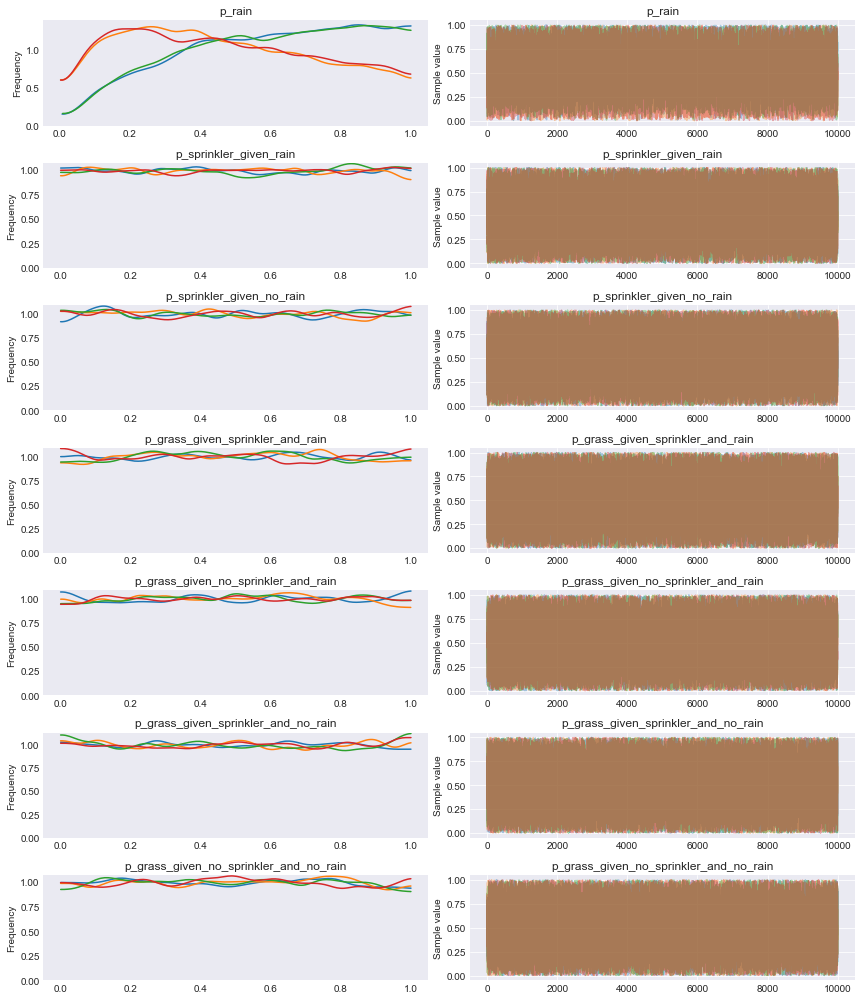

In [15]:
_ = pm.traceplot(trace)